In [80]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sb

In [81]:
data = pd.read_csv("parfumo_data.csv")
data = data.drop(['name'], axis=1)
data =data.dropna()


In [82]:
target = data.filter(["rating"])

## Eval Accords

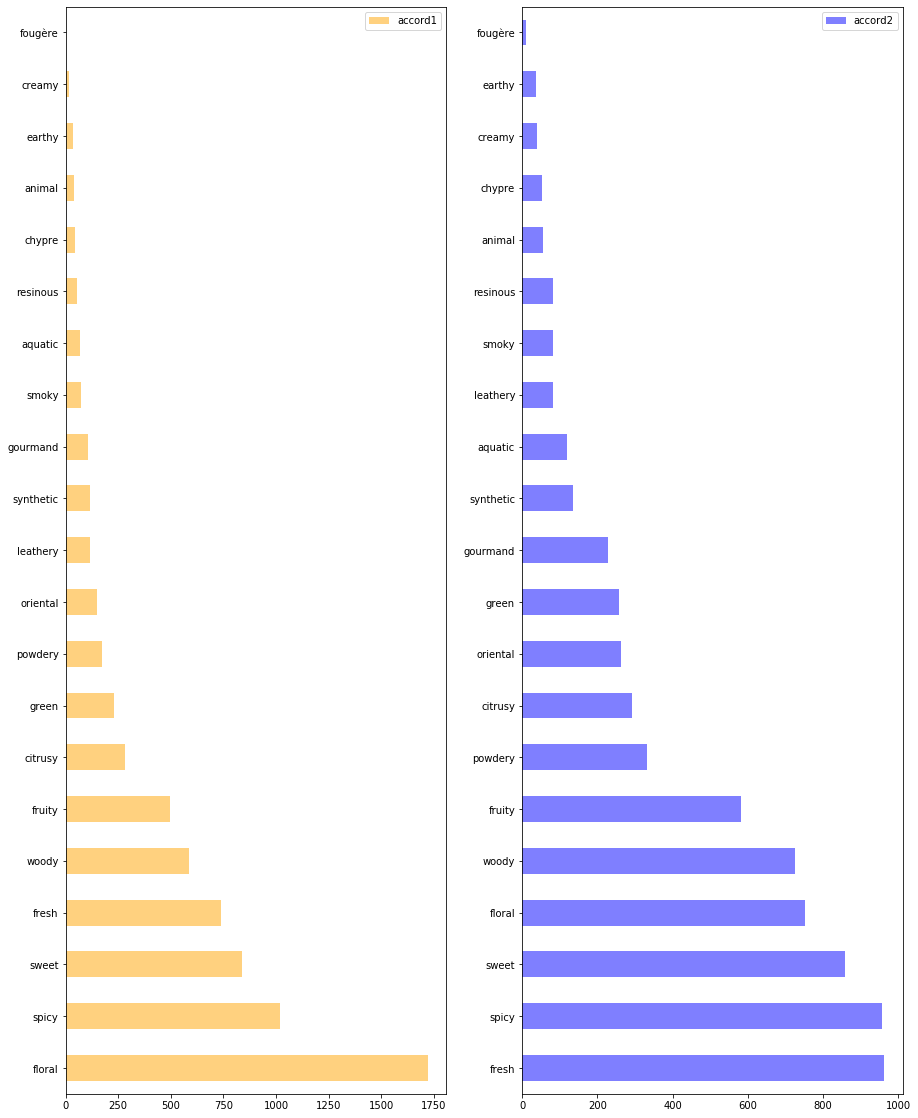

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,20))
data["accord1"].value_counts().plot(kind="barh", alpha=0.5, legend=True, color="orange", ax=axes[0])
data["accord2"].value_counts().plot(kind="barh", alpha=0.5, legend=True, color="blue", ax=axes[1])


## Encode Categories

In [84]:
data['accord1'] = data['accord1'].astype('category')
data['accord2'] = data['accord1'].astype('category')

In [85]:
display(data)

,brand,year,rating,votes,longevity,sillage,accord1,accord2
0,4160_Tuesdays,2013.0,76.7568,37.0,79.5000,76.5000,sweet,sweet
1,4160_Tuesdays,2015.0,81.5714,35.0,75.4167,67.8261,gourmand,gourmand
2,4160_Tuesdays,2016.0,76.7742,31.0,83.9130,76.5217,fruity,fruity
4,4160_Tuesdays,2013.0,72.9630,27.0,70.2174,63.0435,sweet,sweet
5,4160_Tuesdays,2017.0,80.0000,20.0,79.4118,67.6471,spicy,spicy
...,...,...,...,...,...,...,...,...
8456,Zoologist,2019.0,80.8491,53.0,85.1020,79.7959,aquatic,aquatic
8457,Zoologist,2019.0,73.0769,52.0,86.2791,80.9302,green,green
8458,Zoologist,2017.0,75.0000,51.0,77.6744,73.0233,green,green
8459,Zoologist,2019.0,75.8163,49.0,81.7073,74.3902,floral,floral
